# Multiclass Classification of Fashion-MNIST dataset with Pytorch
## Part-3: Implementing Image Augmentation (or transforms)

@see: [Medium Article](https://towardsdatascience.com/10-tips-for-a-better-google-colab-experience-33f8fe721b82#8c1e) on how to keep Colab notebook from disconnecting -- see point #7. You will need this trick for this notebook as training is run for >75 epochs!

In [1]:
!pip install torchmetrics --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 4.4 MB/s eta 0:00:00


In [2]:
# set this flag to True when you run this Notebook on Google Collaboratory
USE_COLAB = True

# enable auto-reload of any module
%reload_ext autoreload
%autoreload 2

import os
import sys

#@see: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q
if USE_COLAB:
    # Load the Drive helper and mount
    from google.colab import drive

    # This will prompt for authorization.
    gdrive_mount_point = '/content/drive/'
    drive.mount(gdrive_mount_point)
    # now add correct module folder to sys.path
    PYTORCH_NOTEBOOKS_PATH = "/content/drive/My Drive/Colab Notebooks/Pytorch"
    assert os.path.exists(PYTORCH_NOTEBOOKS_PATH), f"FATAL: {PYTORCH_NOTEBOOKS_PATH} does not exist!"
    sys.path.insert(0, PYTORCH_NOTEBOOKS_PATH)
    print(f"sys.path: {sys.path}", flush=True)
    # assert os.path.exists(os.path.join(PYTORCH_NOTEBOOKS_PATH, "torch_training_toolkit.py")), \
    #     f"FATAL ERROR: torch_training_toolkit not found!"
    MODEL_SAVE_DIR = os.path.join(PYTORCH_NOTEBOOKS_PATH, "model_states")
else:
    MODEL_SAVE_DIR = os.path.join('.','model_states')

print(f"Model states will be saved to {MODEL_SAVE_DIR}")

if not os.path.exists(MODEL_SAVE_DIR):
    os.mkdir(MODEL_SAVE_DIR)

# NOTE: torch_training_toolkit is a module, which resides in the torch_training_toolkit
# subfolder of PYTORCH_NOTEBOOKS_PATH, hence we should be able to import it
import torch_training_toolkit as t3
print(t3.about())

Mounted at /content/drive/
sys.path: ['/content/drive/My Drive/Colab Notebooks/Pytorch', '/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython']
Model states will be saved to /content/drive/My Drive/Colab Notebooks/Pytorch/model_states

Torch Training Toolkit (t3): a library to make training, evaluating & predicting of Pytorch models easier.
Created by Manish Bhobé, and released by Nämostuté Ltd. with MIT Licence (for personal or commercial use).
Use at your own risk. Manish Bhobé (or Nämostuté Ltd.) are not liable for any damages from use of this software!


## Standard Imports

In [3]:
import warnings
warnings.filterwarnings('ignore')

import sys, os, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# tweaks for libraries
np.set_printoptions(precision=6, linewidth=1024, suppress=True)
plt.style.use('seaborn-v0_8')
sns.set(style='darkgrid', context='notebook', font_scale=1.2)

# Pytorch imports
import torch
print(f'Using Pytorch version {torch.__version__}. ' +
      f'GPU {"is available :)" if torch.cuda.is_available() else "is not available :("}')
import torch.nn as nn
from torchvision import datasets, transforms
from torch import optim
import torchsummary
import torchmetrics

# My helper functions for training/evaluating etc.
import torch_training_toolkit as t3

SEED = t3.seed_all(41)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using Pytorch version 2.1.0+cu121. GPU is available :)


## Helper Functions

In [4]:
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS = 28, 28, 1

In [5]:
def load_data():
    """
    load the data using datasets API. We also split the test_dataset into
    cross-val/test datasets using 80:20 ration
    """
    mean, std = 0.5, 0.5

    train_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(35),
        transforms.RandomResizedCrop((IMAGE_HEIGHT, IMAGE_WIDTH),scale=(0.8,1.0),ratio=(1.0,1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])


    cross_val_and_test_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    train_dataset =  datasets.FashionMNIST(root='./data', train=True, download=True,
                                   transform=train_transforms)

    print("No of training records: %d" % len(train_dataset))

    test_dataset = datasets.FashionMNIST('./data', train=False, download=True,
                                  transform=cross_val_and_test_transforms)
    print("No of test records: %d" % len(test_dataset))

    # lets split the test dataset into val_dataset & test_dataset -> 8000:2000 records
    val_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [8000, 2000])
    print("No of cross-val records: %d" % len(val_dataset))
    print("No of test records: %d" % len(test_dataset))

    return train_dataset, val_dataset, test_dataset

In [6]:
def display_sample(sample_images, sample_labels, grid_shape=(10, 10), plot_title=None,
                   sample_predictions=None):
    # just in case these are not imported!
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.style.use('seaborn-v0_8')

    num_rows, num_cols = grid_shape
    assert sample_images.shape[0] == num_rows * num_cols

    # a dict to help encode/decode the labels
    FASHION_LABELS = {
        0: 'T-shirt/top',
        1: 'Trouser',
        2: 'Pullover',
        3: 'Dress',
        4: 'Coat',
        5: 'Sandal',
        6: 'Shirt',
        7: 'Sneaker',
        8: 'Bag',
        9: 'Ankle boot',
    }

    with sns.axes_style("whitegrid"):
        sns.set_context("notebook", font_scale=1.10)
        sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

        f, ax = plt.subplots(num_rows, num_cols, figsize=(14, 10),
            gridspec_kw={"wspace": 0.05, "hspace": 0.35}, squeeze=True)  # 0.03, 0.25
        #fig = ax[0].get_figure()
        f.tight_layout()
        f.subplots_adjust(top=0.90) # 0.93

        for r in range(num_rows):
            for c in range(num_cols):
                image_index = r * num_cols + c
                ax[r, c].axis("off")
                # show selected image
                ax[r, c].imshow(sample_images[image_index].squeeze(), cmap="Greys", interpolation='nearest')

                if sample_predictions is None:
                    # but show the prediction in the title
                    title = ax[r, c].set_title(f"{FASHION_LABELS[sample_labels[image_index]]}")
                else:
                    pred_matches_actual = (
                                sample_labels[image_index] == sample_predictions[image_index])
                    if pred_matches_actual:
                        # show title from prediction or actual in green font
                        title = '%s' % FASHION_LABELS[sample_predictions[image_index]]
                        title_color = 'g'
                    else:
                        # show title as actual/prediction in red font
                        title = '%s/%s' % (FASHION_LABELS[sample_labels[image_index]],
                                           FASHION_LABELS[sample_predictions[image_index]])
                        title_color = 'r'

                    # but show the prediction in the title
                    title = ax[r, c].set_title(title)
                    # if prediction is incorrect title color is red, else green
                    plt.setp(title, color=title_color)

        if plot_title is not None:
            plt.suptitle(plot_title)
        plt.show()
        plt.close()

In [7]:
# (down)load the data
train_dataset, val_dataset, test_dataset = load_data()

100%|██████████| 26421880/26421880 [00:01<00:00, 15984248.02it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 268523.89it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5072477.31it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5667264.30it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

No of training records: 60000
No of test records: 10000
No of cross-val records: 8000
No of test records: 2000


images.shape = torch.Size([64, 1, 28, 28]), labels.shape=torch.Size([64])


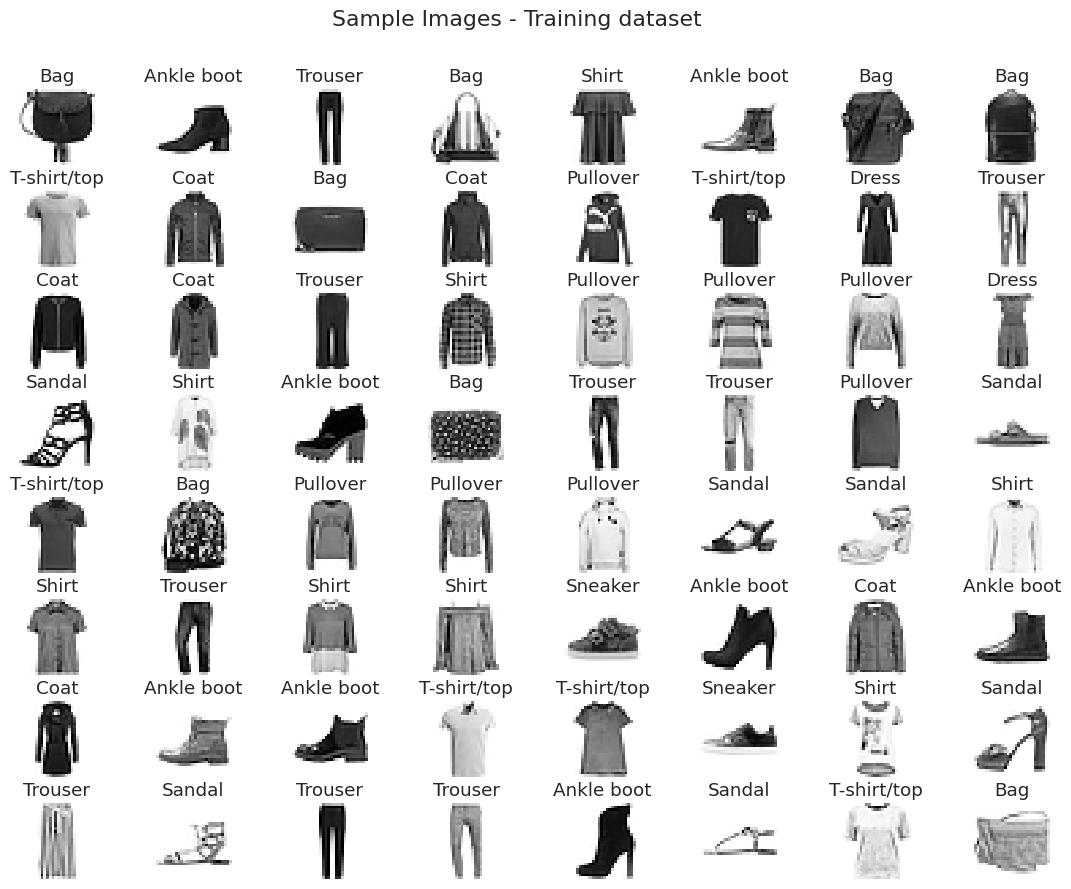

In [8]:
# display a sample
trainloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)
data_iter = iter(trainloader)
images, labels = next(data_iter)  # fetch first batch of 64 images & labels
print(f'images.shape = {images.shape}, labels.shape={labels.shape}')
#print(f'labels = {labels[:10]}')
display_sample(images.cpu().numpy(), labels.cpu().numpy(), grid_shape=(8, 8),
               plot_title='Sample Images - Training dataset')

## Pytorch Model development

In [9]:
# some globals
NUM_CLASSES = 10
NUM_EPOCHS, BATCH_SIZE, LEARNING_RATE, L2_REG = 150, 128, 0.001, 0.0010
PY_MODEL_SAVE_PATH_AUG = os.path.join(MODEL_SAVE_DIR, 'pyt_fashion_mnist_cnn_aug.pyt')
print(f"Model will be saved to {PY_MODEL_SAVE_PATH_AUG}")

Model will be saved to /content/drive/My Drive/Colab Notebooks/Pytorch/model_states/pyt_fashion_mnist_cnn_aug.pyt


In [10]:
class FMNistNetL2DO(nn.Module):
    # dropout is implemented with nn.Dropout() layers in model
    # L2 Reg is implemented in the optimizer
    def __init__(self):
        super(FMNistNetL2DO, self).__init__()
        self.net = nn.Sequential(
            t3.Conv2d(1, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            t3.Conv2d(64, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.20),

            t3.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            t3.Conv2d(128, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.30),

            t3.Conv2d(128, 256, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            t3.Conv2d(256, 256, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.40),

            nn.Flatten(),
            nn.Dropout(0.40),

            nn.Linear(256*3*3, 1024),
            nn.ReLU(),
            nn.Dropout(0.30),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.30),

            nn.Linear(512, NUM_CLASSES)
        )

    def forward(self, x):
        return self.net(x)

In [11]:
model = FMNistNetL2DO().to(DEVICE)
print(torchsummary.summary(model, (NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
              ReLU-2           [-1, 64, 28, 28]               0
       BatchNorm2d-3           [-1, 64, 28, 28]             128
            Conv2d-4           [-1, 64, 28, 28]          36,928
              ReLU-5           [-1, 64, 28, 28]               0
       BatchNorm2d-6           [-1, 64, 28, 28]             128
         MaxPool2d-7           [-1, 64, 14, 14]               0
           Dropout-8           [-1, 64, 14, 14]               0
            Conv2d-9          [-1, 128, 14, 14]          73,856
             ReLU-10          [-1, 128, 14, 14]               0
      BatchNorm2d-11          [-1, 128, 14, 14]             256
           Conv2d-12          [-1, 128, 14, 14]         147,584
             ReLU-13          [-1, 128, 14, 14]               0
      BatchNorm2d-14          [-1, 128,

In [12]:
loss_fn = nn.CrossEntropyLoss()
metrics_map = {
    "acc": torchmetrics.classification.MulticlassAccuracy(num_classes=NUM_CLASSES)
}
trainer = t3.Trainer(
    loss_fn = loss_fn, device=DEVICE, metrics_map = metrics_map,
    epochs=NUM_EPOCHS, batch_size=BATCH_SIZE
)
# L2 reg is implemented in the optimizer
optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE, weight_decay=L2_REG)

In [13]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# learning rate scheduler - reduce learning rate by a factor of 0.10 (10%) when val_loss plateaus
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.10, patience=5, verbose=1)

# early stopping, if val_loss does not improve for 5 epochs, stop training
early_stopping = t3.EarlyStopping(
    model, metrics_map, monitor="val_loss", patience=5, track_after_epoch=50
)

In [13]:
hist = trainer.fit(
    model, optimizer, train_dataset, validation_dataset=val_dataset,
    lr_scheduler=lr_scheduler, early_stopping=early_stopping
)

# hist = trainer.fit(train_dataset, validation_dataset=val_dataset,
#                          epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, lr_scheduler=lr_scheduler)

Cross training on 'cuda' with 60,000 training and 8,000 cross-validation records...
Epoch (  1/150): (60000/60000) -> loss: 0.7980 - acc: 0.7014 - val_loss: 0.5997 - val_acc: 0.7787
Epoch (  2/150): (60000/60000) -> loss: 0.6030 - acc: 0.7798 - val_loss: 0.5220 - val_acc: 0.8016
Epoch (  3/150): (60000/60000) -> loss: 0.5538 - acc: 0.8006 - val_loss: 0.4690 - val_acc: 0.8297
Epoch (  4/150): (60000/60000) -> loss: 0.5273 - acc: 0.8113 - val_loss: 0.4461 - val_acc: 0.8433
Epoch (  5/150): (60000/60000) -> loss: 0.5023 - acc: 0.8235 - val_loss: 0.4187 - val_acc: 0.8512
Epoch (  6/150): (60000/60000) -> loss: 0.4950 - acc: 0.8252 - val_loss: 0.4314 - val_acc: 0.8458
Epoch (  7/150): (60000/60000) -> loss: 0.4832 - acc: 0.8300 - val_loss: 0.7310 - val_acc: 0.7457
Epoch (  8/150): (60000/60000) -> loss: 0.4723 - acc: 0.8346 - val_loss: 0.3883 - val_acc: 0.8652
Epoch (  9/150): (60000/60000) -> loss: 0.4635 - acc: 0.8369 - val_loss: 0.4629 - val_acc: 0.8276
Epoch ( 10/150): (60000/60000) -> 

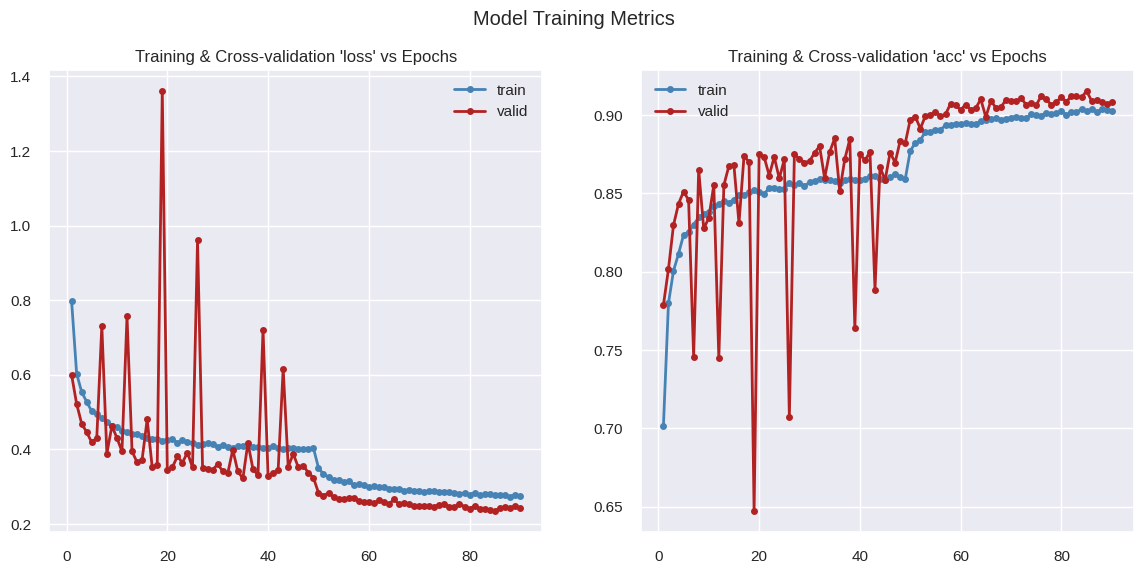

In [14]:
hist.plot_metrics(title = "Model Training Metrics", fig_size = (14, 6))

In [15]:
# evaluate performance
print('Evaluating model performance...')
metrics = trainer.evaluate(model, train_dataset)
print(f"Training metrics -> loss: {metrics['loss']:.4f} - acc: {metrics['acc']:.4f}")
metrics = trainer.evaluate(model, val_dataset)
print(f"Cross-val metrics -> loss: {metrics['loss']:.4f} - acc: {metrics['acc']:.4f}")
metrics = trainer.evaluate(model, test_dataset)
print(f"Testing metrics   -> loss: {metrics['loss']:.4f} - acc: {metrics['acc']:.4f}")

Evaluating model performance...
Evaluating (60000/60000) -> loss: 0.1598 - acc: 0.9258('\rEvaluating (60000/60000) -> loss: 0.2312 - acc: 0.9170',)
Training metrics -> loss: 0.2312 - acc: 0.9170
Evaluating (8000/8000) -> loss: 0.1838 - acc: 0.9133('\rEvaluating (8000/8000) -> loss: 0.2349 - acc: 0.9144',)
Cross-val metrics -> loss: 0.2349 - acc: 0.9144
Evaluating (2000/2000) -> loss: 0.2245 - acc: 0.9026('\rEvaluating (2000/2000) -> loss: 0.2613 - acc: 0.9107',)
Testing metrics   -> loss: 0.2613 - acc: 0.9107


### Observations

>Configuration | Training Acc | Cross-val Acc | Test Acc | Observation
>:---|:---:|:---:|:---:|:---|
>**Model**|99.40%|92.94%|92.69%| Overfitting
>**Base Model + L2 regularization**|~96-97%|~92-93%|~92-93%| Overfitting has reduced
>**Base Model + Dropout regularization**|~97-98%|~93-94%|~92-93%| Overfitting is almost same as before
>**Base Model + Dropout & L2 regularization**|~93-94%|~91-92%|91-92%| Overfitting has reduced.
>**Base Model + Dropout & L2 regularization + Image Aug**|~91-92%|~91-92%|~91-92%| No overfitting! But accuracy could be much better.

After image augmentation, the model appears to handle overfitting really well - all accuracies are in the same range. From the plots, it doesn't appear that the lines will converge, so no point training for more epochs.

**Conclusion**:
* Image Augmentation has helped immensely handle over-fitting
* However our model appears to be very simple for the augmented images (as accuracies are much lower on all 3 datasets).

Time to use a pre-trained model??

In [16]:
t3.save_model(model, PY_MODEL_SAVE_PATH_AUG)
del model

Pytorch model saved to /content/drive/My Drive/Colab Notebooks/Pytorch/model_states/pyt_fashion_mnist_cnn_aug.pyt


### Making Predictions

In [14]:
del model
model = FMNistNetL2DO().to(DEVICE)
t3.load_model(model, PY_MODEL_SAVE_PATH_AUG)
print(torchsummary.summary(model, (NUM_CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT)))

Pytorch model loaded from /content/drive/My Drive/Colab Notebooks/Pytorch/model_states/pyt_fashion_mnist_cnn_aug.pyt
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
              ReLU-2           [-1, 64, 28, 28]               0
       BatchNorm2d-3           [-1, 64, 28, 28]             128
            Conv2d-4           [-1, 64, 28, 28]          36,928
              ReLU-5           [-1, 64, 28, 28]               0
       BatchNorm2d-6           [-1, 64, 28, 28]             128
         MaxPool2d-7           [-1, 64, 14, 14]               0
           Dropout-8           [-1, 64, 14, 14]               0
            Conv2d-9          [-1, 128, 14, 14]          73,856
             ReLU-10          [-1, 128, 14, 14]               0
      BatchNorm2d-11          [-1, 128, 14, 14]             256
           Conv2d-12          [-1, 128, 14, 14]   

In [15]:
# run predictions
y_pred, y_true = trainer.predict(model, test_dataset)
y_pred = np.argmax(y_pred, axis=1)
print('Sample labels (50): ', y_true[:50])
print('Sample predictions (50): ', y_true[:50])
print('We got %d/%d incorrect!' % ((y_pred != y_true).sum(), len(y_true)))

Sample labels (50):  [6 4 5 4 8 0 8 9 5 3 5 4 3 3 0 9 1 2 5 0 8 9 8 0 6 4 7 6 5 0 1 8 1 1 9 7 0 7 5 3 4 4 2 1 9 5 8 4 8 0]
Sample predictions (50):  [6 4 5 4 8 0 8 9 5 3 5 4 3 3 0 9 1 2 5 0 8 9 8 0 6 4 7 6 5 0 1 8 1 1 9 7 0 7 5 3 4 4 2 1 9 5 8 4 8 0]
We got 182/2000 incorrect!


Displaying sample predictions...


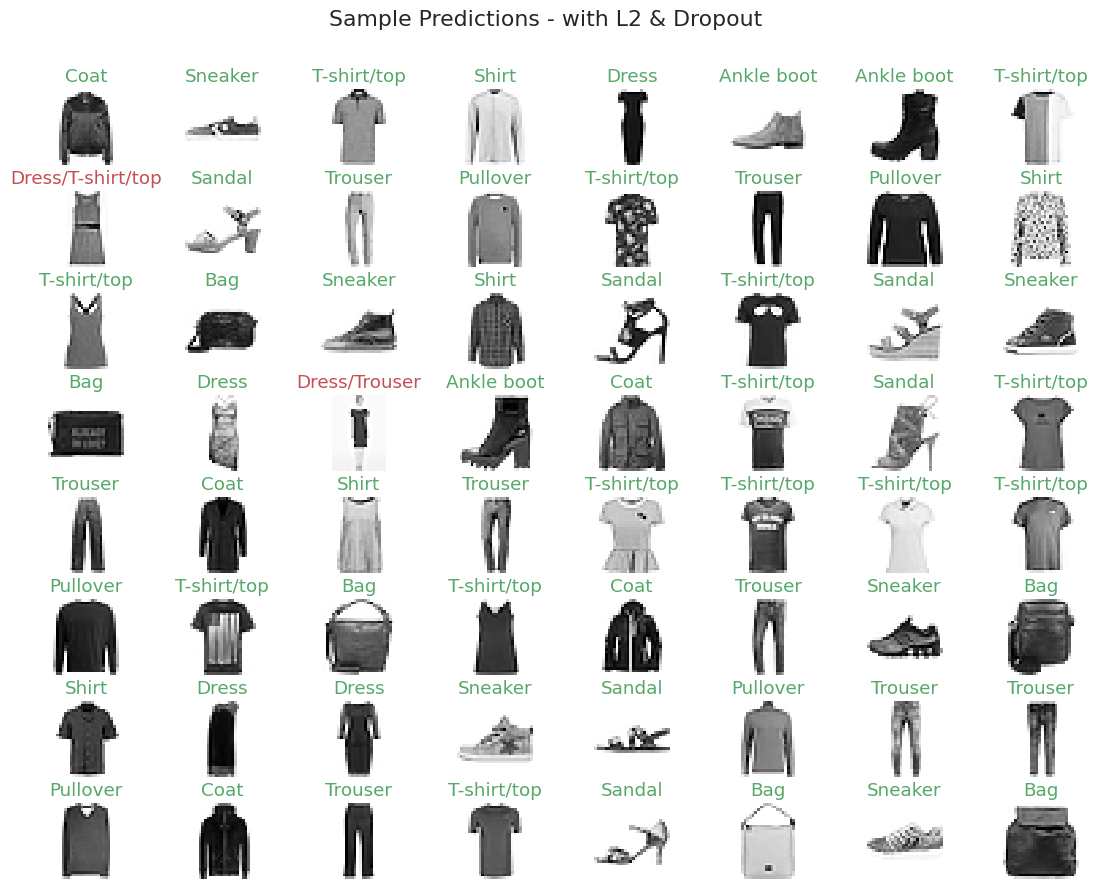

In [16]:
# display sample
print('Displaying sample predictions...')
trainloader = torch.utils.data.DataLoader(
    test_dataset, batch_size = 64, shuffle = True
)
data_iter = iter(trainloader)
images, labels = next(data_iter)  # fetch a batch of 64 random images
preds = trainer.predict(model, images)
preds = np.argmax(preds, axis = 1)
display_sample(
    images, labels.numpy(), sample_predictions = preds,
    grid_shape = (8, 8), plot_title = 'Sample Predictions - with L2 & Dropout'
)

#  <center> -- END -- </center>